# Курсовой проект
## Теория вероятностей и математической статистики

### Сбор данных

In [42]:
import chess.pgn
import csv
import re

In [ ]:
pgn = open("KingBase2019-A40-A79.pgn")
with open('chess.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['date', 'result', 'white_elo', 'black_elo', 'moves',])
    game = chess.pgn.read_game(pgn)
    while game:
        if game.headers['Result'] == '1-0':
            result = 1
        elif game.headers['Result'] == '0-1':
            result = -1
        else:
            result = 0
        writer.writerow([
            game.headers['Date'], 
            result, 
            int(game.headers['WhiteElo']), 
            int(game.headers['BlackElo']),
            int(re.search(r'^\d+', str(game.end())).group(0)),
        ])
        game = chess.pgn.read_game(pgn)

### Обзор данных

In [330]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline
pd.options.display.max_columns = 100
plt.style.use('seaborn-whitegrid')

In [331]:
data = pd.read_csv('chess.csv')
data.loc[lambda df: df.result > 0, 'winner_elo'] = data.loc[lambda df: df.result > 0, 'black_elo']
data.loc[lambda df: df.result < 0, 'winner_elo'] = data.loc[lambda df: df.result < 0, 'white_elo']
data.loc[lambda df: df.result < 0, 'loser_elo'] = data.loc[lambda df: df.result < 0, 'black_elo']
data.loc[lambda df: df.result > 0, 'loser_elo'] = data.loc[lambda df: df.result > 0, 'white_elo']
data.loc[lambda df: ~df.winner_elo.isnull() & ~df.loser_elo.isnull(), 'winner_elo_diff'] = data.loc[lambda df: ~df.winner_elo.isnull() & ~df.loser_elo.isnull(), 'winner_elo'] - data.loc[lambda df: ~df.winner_elo.isnull() & ~df.loser_elo.isnull(), 'loser_elo']
data.head(5)

,date,result,white_elo,black_elo,moves,winner_elo,loser_elo,winner_elo_diff
0,2018.12.31,0,2436,2240,24,NaN,NaN,NaN
1,2018.12.31,0,2228,2544,36,NaN,NaN,NaN
2,2018.12.31,1,2438,2189,42,2189.0,2438.0,-249.0
3,2018.12.31,0,2485,2547,66,NaN,NaN,NaN
4,2018.12.31,-1,2289,2484,59,2289.0,2484.0,-195.0


* `date` – дата, когда состоялась партия
* `result` $\in$ (-1, 0, +1) – кто победил, соответственно: белые, ничья, чёрные
* `white_elo` – рейтинг elo белого игрока
* `black_elo` – рейтинг elo чёрного игрока
* `moves` – количество ходов в партии
* `winner_elo` – рейтинг elo победителя
* `loser_elo` – рейтинг elo проигравшего
* `winner_elo_diff` – разница между рейтингом elo победителя и проигравшего

In [332]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35706 entries, 0 to 35705
Data columns (total 8 columns):
date               35706 non-null object
result             35706 non-null int64
white_elo          35706 non-null int64
black_elo          35706 non-null int64
moves              35706 non-null int64
winner_elo         24639 non-null float64
loser_elo          24639 non-null float64
winner_elo_diff    24639 non-null float64
dtypes: float64(3), int64(4), object(1)
memory usage: 2.2+ MB


### Исследуем колонку moves

Найдём выборочные среднее, дисперсию, стантартное квадратическое отклонение и моду:

In [333]:
n = data.moves.count()
print('n =', n)

avg = data.moves.mean()
print('avg =', avg)

n = 35706
avg = 43.57189267910155


In [334]:
var = data.moves.var(ddof=1)
print('var =', var)

std = data.moves.std(ddof=1)
print('std =', std)

var = 309.75426275011193
std = 17.599837009191646


In [335]:
mode = data.moves.mode()[0]
print('mode =', mode)

mode = 40


In [336]:
data.moves.value_counts()

40     1176
41     1040
39      983
35      975
38      965
       ... 
163       1
168       1
174       1
166       1
159       1
Name: moves, Length: 150, dtype: int64

Посчитаем межквартильный интервал и построим boxplot

In [337]:
q1 = data.moves.quantile(0.25)
print('q1 =', q1)

median = data.moves.median()
print('median =', median)

q3 = data.moves.quantile(0.75)
print('q3 =', q3)

p90 = data.moves.quantile(0.90)
print('p90 =', p90)

iqr = (q3 - q1) * 1.5
print('iqr =', iqr)

(q1 - iqr, q3 + iqr)

q1 = 32.0
median = 41.0
q3 = 53.0
p90 = 66.0
iqr = 31.5


(0.5, 84.5)

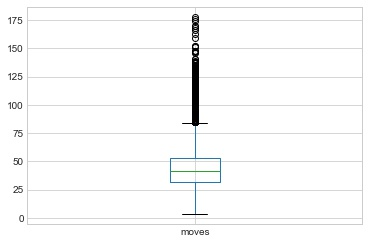

In [338]:
data.boxplot(column='moves')

### Функция распределения

Построим эмпирическую функцию распределения:

In [339]:
def edf(samples, x: float) -> float:
    return samples[samples < x].shape[0] / samples.shape[0]

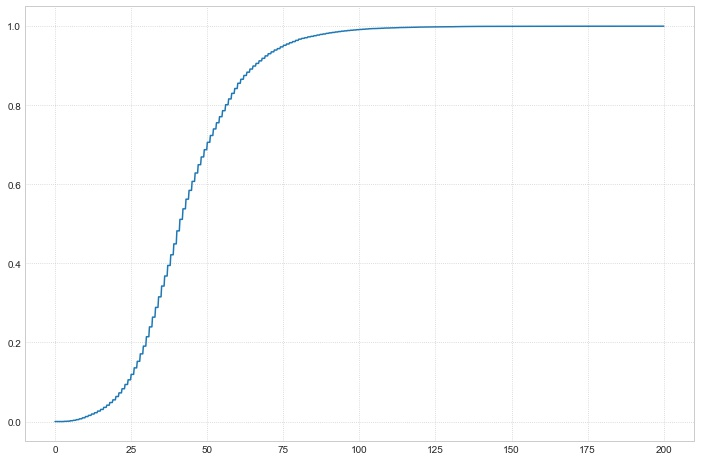

In [340]:
plt.figure(figsize=(12, 8))

ox = np.linspace(0, 200, 1000)
oy = np.array([edf(data.moves, x) for x in ox])

plt.plot(ox, oy)

plt.grid(linestyle='dotted')
plt.show()

Построим плотность распределения и сравним её с нормальной плотностью распределения:

In [341]:
def pdf_normal(loc: float, scale: float, x: float) -> float:
    return np.exp(- ((x - loc) ** 2) / (2 * scale ** 2)) / (scale * np.sqrt(2 * np.pi))

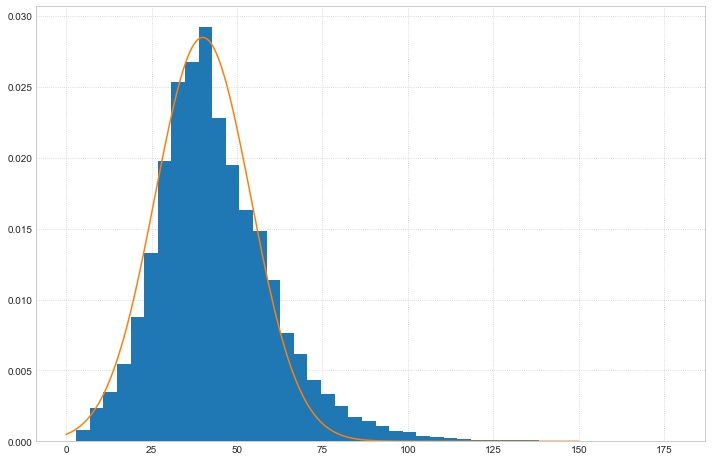

In [342]:
plt.figure(figsize=(12, 8))

ox = np.linspace(0, 150, 1000)
oy = np.array([pdf_normal(mode, 14, x) for x in ox])

plt.hist(data.moves, density=True, bins=44)
plt.plot(ox, oy)

plt.grid(linestyle='dotted')
plt.show()

### Проверка гипотезы о нормальном распределении

На графическом представлении данных видно, что распределение выборки напоминает нормальное. Проверим, что генеральная совокупность имеет нормальное распределение с $M(X) = mode = 40$ и $\sigma = 14$, приняв уровень значимости $\alpha = 0.01$.

Значение $M(X)$ взяли равной моде, как самому частовстречающемуся значению. Значение $\sigma$ было подобрано экспериментально графическим способом.

Воспользуемся критерием согласия Колмогорова:

`kstest(rvs, cdf)`

Аргументы:
* rvs – выборка,
* cdf – функция распределения.

Возвращает:
* statistic – статистика критерия,
* pvalue – число, которое имеет следующий смысл: если меньше уровня значимости $\alpha$, то гипотеза $H_0$ отвергается, в противном случае гипотеза $H_0$ не отвергается.

Источник: https://mipt-stats.gitlab.io/files/mathstats_fbmf_19/seminar4.pdf

In [343]:
mode, std, n

(40, 17.599837009191646, 35706)

In [344]:
cdf = stats.norm(loc=mode, scale=14).cdf

In [345]:
kstest = stats.kstest(rvs=data.moves, cdf=cdf, alternative='greater')
kstest

KstestResult(statistic=0.0, pvalue=1.0)

In [346]:
alpha = 0.01
kstest.pvalue > alpha

True

Распределение является нормальным.

### Корреляционный анализ

In [347]:
data.dropna()[['moves', 'winner_elo', 'winner_elo_diff']].corr()

,moves,winner_elo,winner_elo_diff
moves,1.000000,0.109673,0.133336
winner_elo,0.109673,1.000000,0.540927
winner_elo_diff,0.133336,0.540927,1.000000


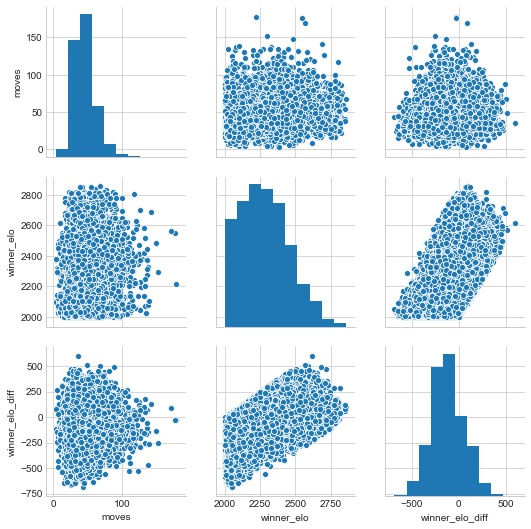

In [348]:
sns.pairplot(data.dropna()[['moves', 'winner_elo', 'winner_elo_diff']])

Мы видим, небольшую положительную корелляцию между количеством ходов, сделанных в партии, и уровнем elo победителя. Так как корреляция Пирсона показывает линейную зависимость, то можно сделать вывод, что более высокоуровневые игроки чаще играют долгие партии.

Также наблюдаем положительную корелляцию между количеством ходов, сделанных в партии, и разницей elo игроков. Получается, что победить игрока с рейтингом ниже своего – не всегда задача из лёгких.

Корреляция между рейтингом победителя и разницей рейтингов равна 0.54. Следовательно, если рейтинг игрока ниже, то это не всегда будет означать его проигрыш.

### Интересные факты (Выводы)
* В среднем, на шахматном турнире игроки успевают сделать по $44$ хода.
* Партии, которые закончились на $40$ ходу, встречаются чаще, чем другие.
* $90\%$ партий заканчиваются до $66$ хода.
* Партии, у которых более $84$ ходов крайне редки. Шанс увидеть такую – меньше трёх из 100.
* Игроки с высоким рейтингом любят поиграть дольше, также, как игроки с большой разницей в рейтинге.
* Если рейтинг игрока выше, то шансы на победу всё равно близки к $\frac{1}{2}$.